<a href="https://colab.research.google.com/github/YashVarshney24/COG_Practice/blob/main/LifeOnPlaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('dataset.csv',index_col=False)
data

,Life,O2,O3,H2O,N2,H2,Sunlight,Aliens,Plants
0,10,1,36,42,9,8,1,1,0
1,3,30,22,1,26,1,0,0,1
2,4,28,3,42,28,36,0,1,0
3,3,25,22,68,11,34,1,1,1
4,3,38,14,78,20,13,0,1,1
...,...,...,...,...,...,...,...,...,...
195,7,15,15,75,14,26,0,0,0
196,4,22,2,48,11,4,0,0,0
197,1,4,27,30,31,7,0,0,0
198,1,18,23,47,28,9,0,1,1


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
X = data.drop('Life', axis = 1)
y = data['Life']

In [6]:
from sklearn.pipeline import Pipeline #sklearn==0.23.2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier

tuples = list()

tuples.append((Pipeline([
        ('scaler', StandardScaler()),
    ]), ["O2","O3","H2O","N2","H2"]))


preprocess = make_column_transformer(*tuples)

pipe = Pipeline([
    ('preprocess', preprocess),
    ('classifier', LGBMClassifier())
])

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": [0.0001, 0.0005, 0.001, 0.01, 0.1],
    "classifier__n_estimators": [100, 300, 600, 800, 1000],
    "classifier__max_depth": [ 4, 20, 100, 250, 400] 
}

# grid
reg_grid = GridSearchCV(pipe,
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=8, 
                        scoring='roc_auc'
                       )

model_grid = reg_grid.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

n_iter = 70

param_grid = {
    "classifier__learning_rate": loguniform(1e-4, 0.1),
    "classifier__n_estimators": randint(100,1000),
    "classifier__max_depth": randint(4, 400) 
}

# Random
reg_rand = RandomizedSearchCV(pipe,
                         param_distributions=param_grid,
                         n_iter=n_iter,
                         cv=5,
                         n_jobs=8,
                         scoring='roc_auc',
                         random_state=123)

model_rand = reg_rand.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


In [14]:
!pip3 install scikit-optimize


In [16]:
from skopt import BayesSearchCV

# Bayesian
n_iter = 70

param_grid = {
    "classifier__learning_rate": (0.0001, 0.1, "log-uniform"),
    "classifier__n_estimators": (100,  1000) ,
    "classifier__max_depth": (4, 400) 
}

reg_bay = BayesSearchCV(estimator=pipe,
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=5,
                    n_jobs=8,
                    random_state=123)

model_bay = reg_bay.fit(X, y)


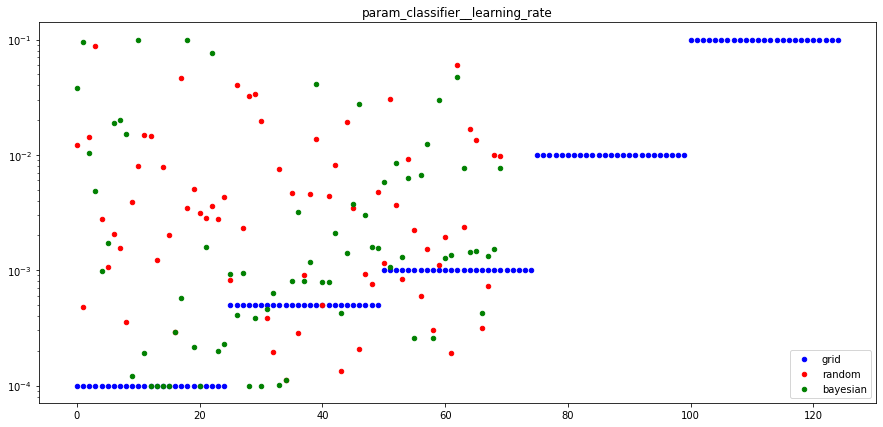

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline

param = 'param_classifier__learning_rate'

grid = model_grid.cv_results_[param]
rand = model_rand.cv_results_[param]
bay = model_bay.cv_results_[param]

fig = plt.figure(figsize=(15, 7))

ax = plt.gca()
ax.scatter(np.arange(len(grid)), grid.data, c='b', s=20, label='grid');
ax.scatter(np.arange(len(rand)), rand.data, c='r', s=20, label='random');
ax.scatter(np.arange(len(bay)), bay, c='g', s=20, label='bayesian');
ax.set_yscale('log')

plt.legend();
plt.title(param);
